In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import os
import scanpy as sc
from statsmodels.stats.multitest import multipletests
import sys
sys.path.append("../src")
from evaluation_metrics import *

In [2]:
def round_sig(x, sig=2):
    if pd.isna(x) or x == 0:
        return x
    return round(x, -int(np.floor(np.log10(abs(x)))) + (sig - 1))

In [3]:
results = "../evaluation_results/pertpy_data/"
result_dfs = {f.split("_results.txt")[0]: pd.read_csv(os.path.join(results, f)) for f in os.listdir(results) if f.endswith("results.txt")}

In [4]:
for df in result_dfs:
    result_dfs[df][["z", "p"]] = result_dfs[df][["z", "p"]].map(lambda x: round_sig(x, sig=2))
    result_dfs[df]["$P_{adj}$"] = multipletests(result_dfs[df]["p"], method="fdr_bh")[1]
    result_dfs[df]["$cov$"] = result_dfs[df]["s"] 
    result_dfs[df]["$z$"] = result_dfs[df]["z"] 

In [5]:
for dataset in result_dfs:
    p_mon = monotonicity(result_dfs[dataset].sort_values("test_group")["p"], smaller_is_stronger=True)
    z_mon = monotonicity(result_dfs[dataset].sort_values("test_group")["z"], smaller_is_stronger=True)
    print(dataset, p_mon, z_mon)

mcfarland 1.0 1.0
sciplex_MCF7 1.0 1.0
sciplex_K562 0.6666666666666666 0.5
sciplex_A549 1.0 1.0
schiebinger 1.0 0.39928698752228164
norman 1.0 1.0


In [6]:
results_within = "../evaluation_results/within/"
result_dfs_within = {f.split("_results.txt")[0].split("within_")[1]: pd.read_csv(os.path.join(results_within, f)).set_index("test_group") for f in os.listdir(results_within) if "within" in f}

In [7]:
result_dfs_within["norman"]
for dataset in result_dfs:
    print(dataset)
    ps = list()
    zs = list()
    for group in result_dfs_within[dataset]["reference"].unique():
        if group in ["control", "0.0", 0.0]:
            print(group)
            continue
        sub_res = result_dfs_within[dataset].loc[group]
        ps.append(sub_res["p"].values)
        zs.append(sub_res["z"].values)
    ps = np.stack(ps)
    zs = np.stack(zs)
    print(result_dfs[dataset]["p"].shape)
    print(ps.shape)
    print(dataset, SSNR(result_dfs[dataset]["p"], ps, smaller_is_stronger=True), SSNR(result_dfs[dataset]["z"], zs, smaller_is_stronger=True))
    #    p_mon = monotonicity(result_dfs[dataset].sort_values("test_group")["p"], smaller_is_stronger=True)
    #    z_mon = monotonicity(result_dfs[dataset].sort_values("test_group")["z"], smaller_is_stronger=True)
    #print(dataset, p_mon, z_mon)

mcfarland
control
(2,)
(2, 6)
mcfarland 1.0 1.0
sciplex_MCF7
0.0
(4,)
(3, 6)


AssertionError: 

In [ ]:
result_dfs["sciplex_MCF7"]

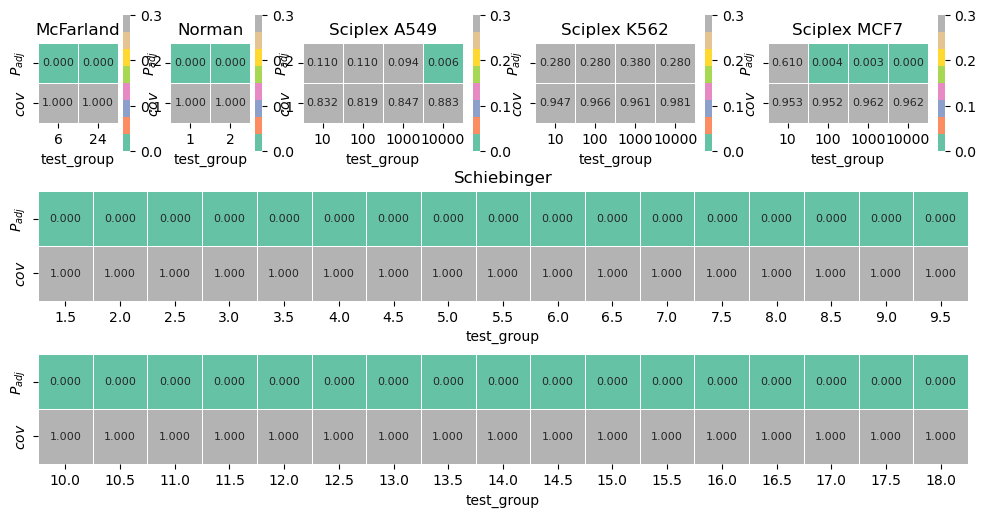

In [18]:
alpha = 0.05
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 2, 2, 2])

ax1 = fig.add_subplot(gs[0, 0], sharey=None)
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
ax6 = fig.add_subplot(gs[1, :], sharey=ax1)
ax7 = fig.add_subplot(gs[2, :], sharey=ax1)

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

vmin = 0
vmax = 0.3

datasets = ["mcfarland", "norman", "sciplex_A549", "sciplex_K562", "sciplex_MCF7", "schiebinger"]
names = ["McFarland", "Norman", "Sciplex A549", "Sciplex K562", "Sciplex MCF7", "Schiebinger"]

for i, (dataset, name) in enumerate(zip(datasets, names)):
    data = result_dfs[dataset][["$P_{adj}$", "$cov$", "test_group"]].set_index("test_group").T
    if dataset == "schiebinger":
        data.columns = data.columns.astype(float)
        data = data.sort_index(axis=1)
        data1 = data.iloc[:, :len(data.columns)//2]
        data2 = data.iloc[:, len(data.columns)//2:]        
        sns.heatmap(data1 >= alpha, annot=data1, square=True, ax=axs[i], cbar=False, vmin=vmin, vmax=vmax, linewidth=.5, fmt=".3f", cmap="Set2", annot_kws={"size": 8})
        sns.heatmap(data2 >= alpha, annot=data2, square=True, ax=axs[i + 1], cbar=False, vmin=vmin, vmax=vmax, linewidth=.5, fmt=".3f", cmap="Set2", annot_kws={"size": 8})
    else:
        data.columns = data.columns.astype(int)
        sns.heatmap(data > alpha, annot=data, square=True, ax=axs[i], cbar=True, vmin=vmin, vmax=vmax, linewidth=.5, fmt=".3f", cmap="Set2", annot_kws={"size": 8})
    axs[i].set_title(name)

#plt.tight_layout()
plt.savefig("../plots/fig3/scrnaseq1.pdf", bbox_inches="tight")
plt.show()

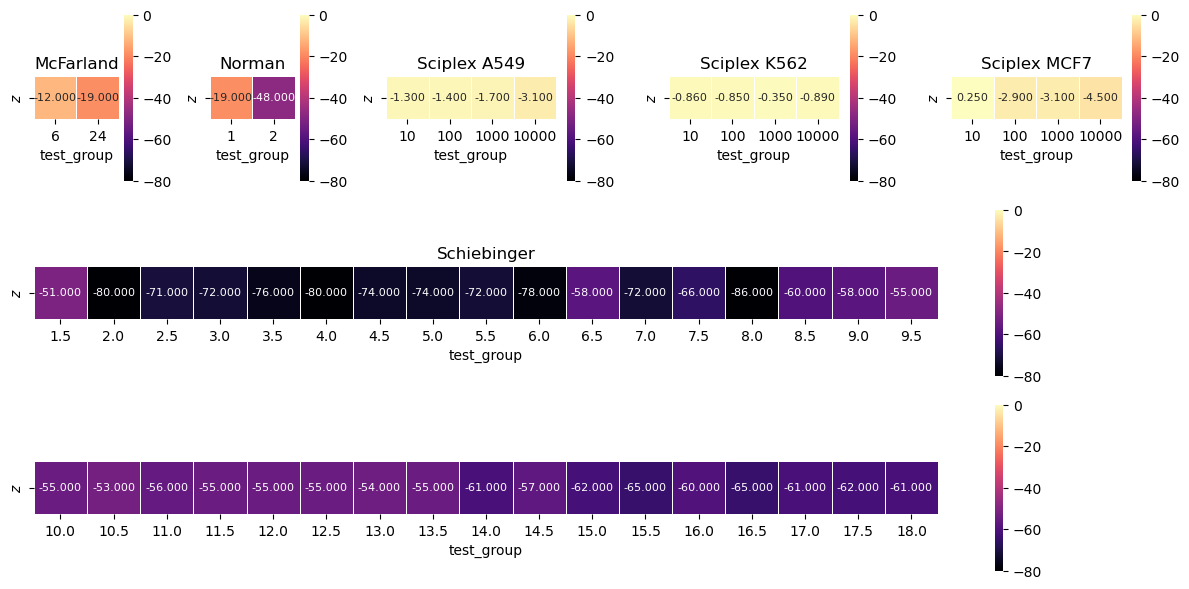

In [17]:
alpha = 0.05
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 2, 2, 2])

ax1 = fig.add_subplot(gs[0, 0], sharey=None)
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
ax6 = fig.add_subplot(gs[1, :], sharey=ax1)
ax7 = fig.add_subplot(gs[2, :], sharey=ax1)

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

vmin = -80
vmax = 0

datasets = ["mcfarland", "norman", "sciplex_A549", "sciplex_K562", "sciplex_MCF7", "schiebinger"]
names = ["McFarland", "Norman", "Sciplex A549", "Sciplex K562", "Sciplex MCF7", "Schiebinger"]

for i, (dataset, name) in enumerate(zip(datasets, names)):
    data = result_dfs[dataset][["$z$", "test_group"]].set_index("test_group").T
    if dataset == "schiebinger":
        data = data.sort_index(axis=1)
        data.columns = data.columns.astype(float)
        data1 = data.iloc[:, :len(data.columns)//2]
        data2 = data.iloc[:, len(data.columns)//2:]        
        sns.heatmap(data1, annot=data1, square=True, ax=axs[i], cbar=True, vmin=vmin, vmax=vmax, linewidth=.5, fmt=".3f", cmap="magma", annot_kws={"size": 8})
        sns.heatmap(data2, annot=data2, square=True, ax=axs[i + 1], cbar=True, vmin=vmin, vmax=vmax, linewidth=.5, fmt=".3f", cmap="magma", annot_kws={"size": 8})
    else:
        data.columns = data.columns.astype(int)
        sns.heatmap(data, annot=data, square=True, ax=axs[i], cbar=True, vmin=vmin, vmax=vmax, linewidth=.5, fmt=".3f", cmap="magma", annot_kws={"size": 8})
    axs[i].set_title(name)

plt.tight_layout()
plt.savefig("../plots/fig3/scrnaseq2.pdf", bbox_inches="tight")
plt.show()